Plot the results

In [33]:
from pyrtid.utils import NDArrayFloat
from matplotlib.axes import Axes
from typing import Optional
import numpy as np
import nested_grid_plotter as ngp
from pathlib import Path
import os
import pyrtid.forward as dmfwd
import pyrtid.inverse as dminv
import copy
import matplotlib.pyplot as plt

In [34]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

# Define some configuration for the plots

In [35]:
# Some configs for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
    "axes.facecolor": "w",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.plot()
plt.close()  # required for the plot to update
plt.rcParams.update(new_rc_params)

- Define the plot functions

In [36]:
def make_symmetric_bins(bins: NDArrayFloat) -> NDArrayFloat:
    step = np.diff(bins)[0]
    if np.abs(bins[-1]) > np.abs(bins[0]):
        nbins = int(bins[bins > 0].size * 2)
        return np.ones(nbins) * bins[-1] - np.arange(nbins - 1, -1, step=-1) * step
    else:
        nbins = int(bins[bins < 0].size * 2)
        return np.ones(nbins) * bins[0] + np.arange(0, nbins) * step


def plot_histogram(
    ax: Axes, values: NDArrayFloat, ax_title: str, scaling_factor=1.0
) -> None:
    """
    Plot residuals histogram.

    Parameters
    ----------
    ax : Axes
        Axis on which to plot the histogram.
    values : NDArrayFloat
        Values of the residuals (shape does not matter).
    scaling_factor : _type_, optional
        Factor to apply so that the residuals are of the same magnitude as the
        gradient values, by default 1e5
    """
    _values = values.ravel()
    # plot the histogram
    n, bins, patches = ax.hist(
        x=_values, bins=20, color="#0504aa", alpha=0.7, density=True
    )

    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    # ax.set_ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

    sigma = np.std(_values)
    mu = np.mean(_values)

    # Set the average line ---(red)
    ax.axvline(values.mean(), color="r", linestyle="dashed", linewidth=1)
    # Display the average and the standard deviation on the graph
    min_xlim, max_xlim = ax.get_xlim()
    min_ylim, max_ylim = ax.get_ylim()
    # calculate the text (x, y) position
    x_pos = values.mean() + 0.15 * (max_xlim - min_xlim)
    y_pos = max_ylim * 0.8
    ax.text(
        x_pos,
        y_pos,
        r"$\mu$: {:.2e}".format(values.mean())
        + "\n"
        + r"$\sigma$: {:.2e}".format(values.std()),
    )

    ax.set_title(ax_title, fontweight="bold")

    # Ensure a symmetric x axis
    ngp.make_x_axes_symmetric_zero_centered([ax])

    # add a 'best fit' line
    min_xlim, max_xlim = ax.get_xlim()
    # _bins = make_symmetric_bins(bins)
    x = np.linspace(min_xlim, max_xlim, 30)
    y = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (x - mu)) ** 2)
    ax.plot(x, y, "--", c="k")

# Load the results

In [37]:
# adjoint
grad_adj_x1 = np.loadtxt("gradient_x1_adj.txt")
grad_adj_x4 = np.loadtxt("gradient_x4_adj.txt")
grad_adj_x16 = np.loadtxt("gradient_x16_adj.txt")

# fd
grad_fd_x1 = np.loadtxt("gradient_x1_fd.txt")
grad_fd_x4 = np.loadtxt("gradient_x4_fd.txt")
grad_fd_x16 = np.loadtxt("gradient_x16_fd.txt")

# Gradient maps

In [38]:
production_locations = [(6, 3, 0), (14, 3, 0)]
injection_locations = [(2, 6, 0), (10, 6, 0), (18, 6, 0)]

nx = 21  # number of voxels along the x axis
ny = 8  # number of voxels along the y axis
nz = 1  # number of voxels along the y axis
# Give non regular dimensions to check if all is correct with mesh dimensions
dx = 8.43  # voxel dimension along the x axis
dy = 5.6
dz = 1.0  # voxel dimension along the y axis
geom_x1 = dmfwd.Geometry(nx=nx, ny=ny, dx=dx, dy=dy, dz=dz)

geom_x4 = copy.deepcopy(geom_x1)
geom_x4.nx *= 2
geom_x4.ny *= 2
geom_x4.dx /= 2
geom_x4.dy /= 2

geom_x16 = copy.deepcopy(geom_x1)
geom_x16.nx *= 4
geom_x16.ny *= 4
geom_x16.dx /= 4
geom_x16.dy /= 4

In [39]:
def plot_gradient_res(
    adj_grad: NDArrayFloat,
    fd_grad: NDArrayFloat,
    geom: dmfwd.Geometry,
    scaling_factor: float,
    fname: str,
    grid_scaling: float = 1.0,
    res_scaling: Optional[float] = None,
) -> None:
    plotter = ngp.NestedGridPlotter(
        fig_params={"constrained_layout": True, "figsize": (10, 8)},
        subplots_mosaic_params={
            "fig0": dict(
                mosaic=[["ax1-1"], ["ax1-2"], ["ax1-3"]],
                sharey=True,
                sharex=True,
            )
        },
    )

    # We multiply the residuals so that the hight residulas is just below the max values
    residuals = adj_grad - fd_grad

    if res_scaling is None:
        res_factor = 1.0
        while np.max(np.abs(adj_grad)) > np.max(np.abs(residuals)) * res_factor:
            res_factor *= 2.0
        # Make sure it is below
        res_factor /= 2.0
    else:
        res_factor = res_scaling

    ngp.multi_imshow(
        axes=plotter.axes,
        fig=plotter.fig,
        data={
            "Finite differences": adj_grad,
            "Adjoint state": fd_grad,
            f"Residuals (x {res_factor:.0e})": residuals * res_factor,
        },
        imshow_kwargs={
            "extent": [0.0, geom.nx * geom.dx, 0.0, geom.ny * geom.dy],
            "aspect": "equal",
        },
        xlabel="X [m]",
        ylabel="Z [m]",
        is_symmetric_cbar=True,
    )

    # plotter.subfigs["fig0"].suptitle(
    #     "J Gradient with respect to permeability", fontweight="bold"
    # )

    for ax in plotter.ax_dict.values():
        # Add some vertical lines to indicate the well
        for well_pos in production_locations:
            ax.plot(
                well_pos[0] * grid_scaling * geom.dx + geom.dx / 2,
                well_pos[1] * grid_scaling * geom.dy + geom.dy / 2,
                label="prod wells",
                marker="^",
                markersize=10,
                c="black",
                linestyle="none",
            )

        for well_pos in injection_locations:
            ax.plot(
                well_pos[0] * grid_scaling * geom.dx + geom.dx / 2,
                well_pos[1] * grid_scaling * geom.dy + geom.dy / 2,
                label="inj wells",
                marker="^",
                markersize=10,
                c="red",
                linestyle="none",
            )

    for format in ["png", "pdf"]:
        plotter.fig.savefig(
            str(fig_save_path.joinpath(f"{fname}.{format}")), format=format
        )

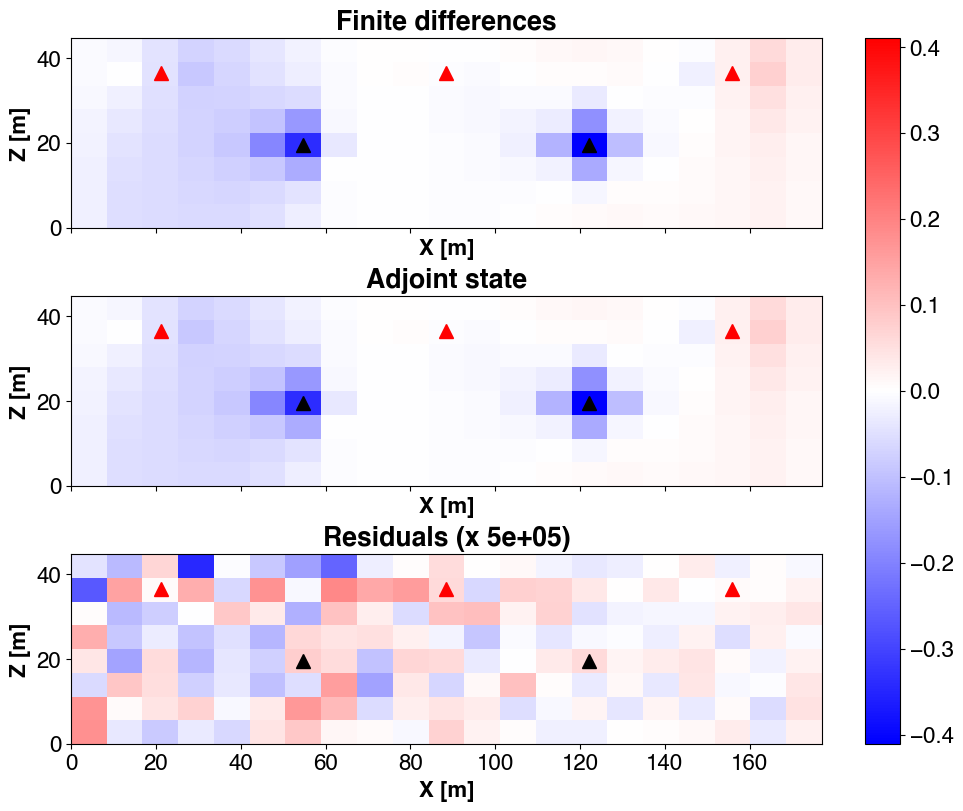

In [40]:
plot_gradient_res(
    grad_adj_x1,
    grad_fd_x1,
    geom_x1,
    1.0,
    "dj_dhc_2d_x1",
    grid_scaling=1,
    res_scaling=5e5,
)

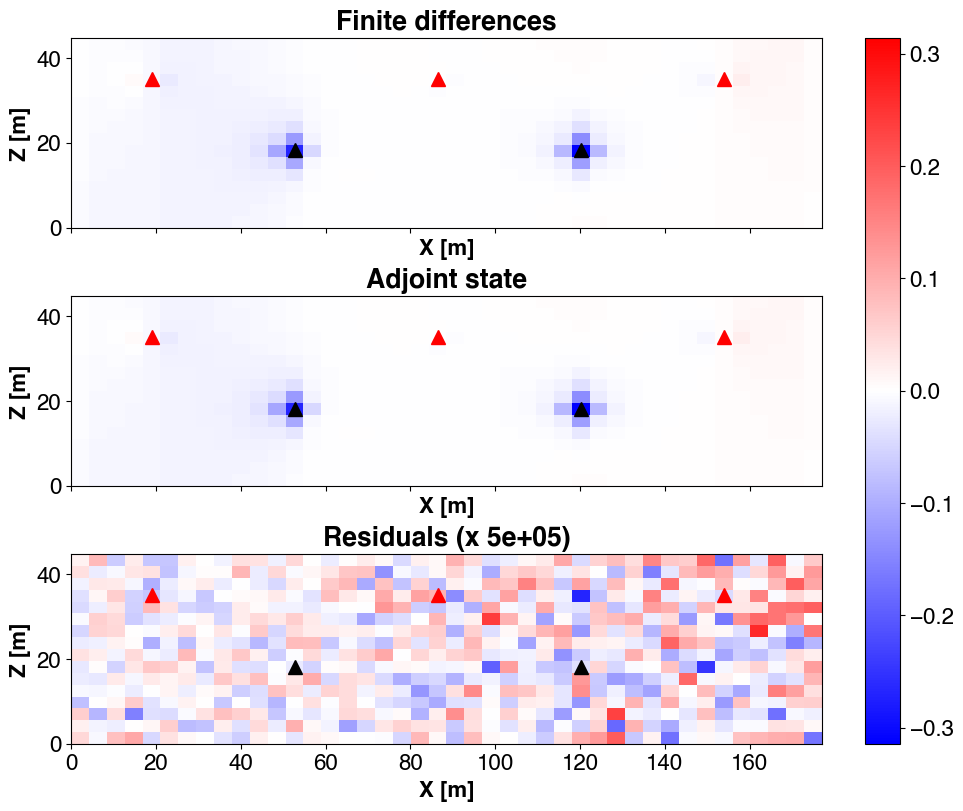

In [41]:
plot_gradient_res(
    grad_adj_x4,
    grad_fd_x4,
    geom_x4,
    1.0,
    "dj_dhc_2d_x4",
    grid_scaling=2,
    res_scaling=5e5,
)

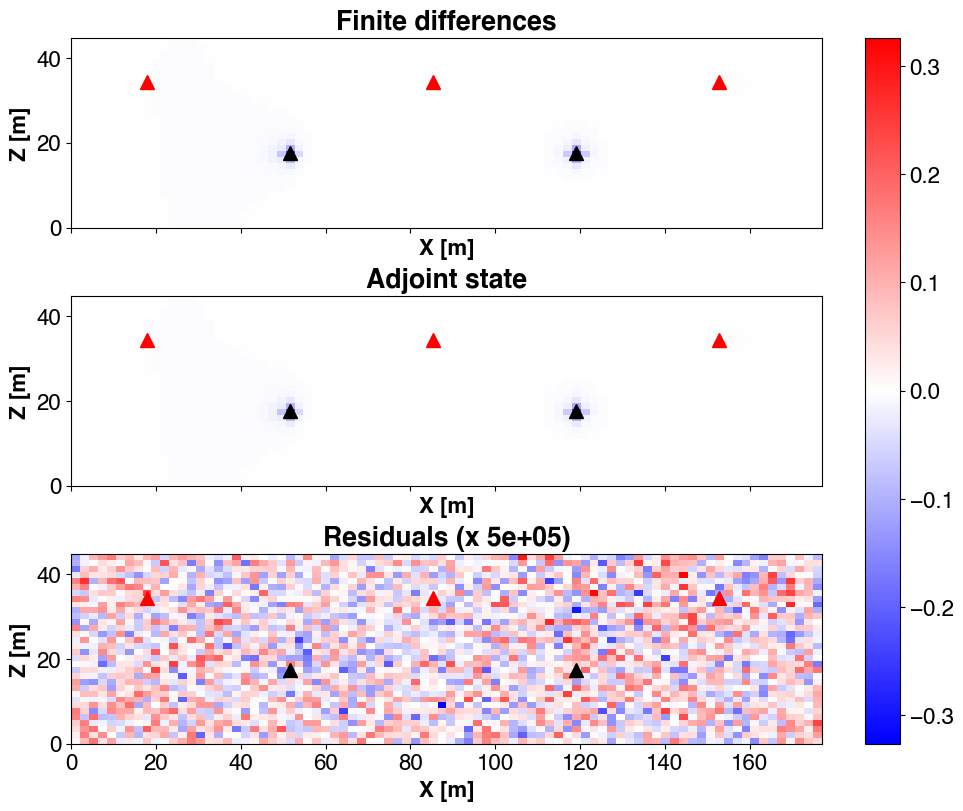

In [42]:
plot_gradient_res(
    grad_adj_x16,
    grad_fd_x16,
    geom_x16,
    1.0,
    "dj_dhc_2d_x16",
    grid_scaling=4,
    res_scaling=5e5,
)

# Gradient distribution

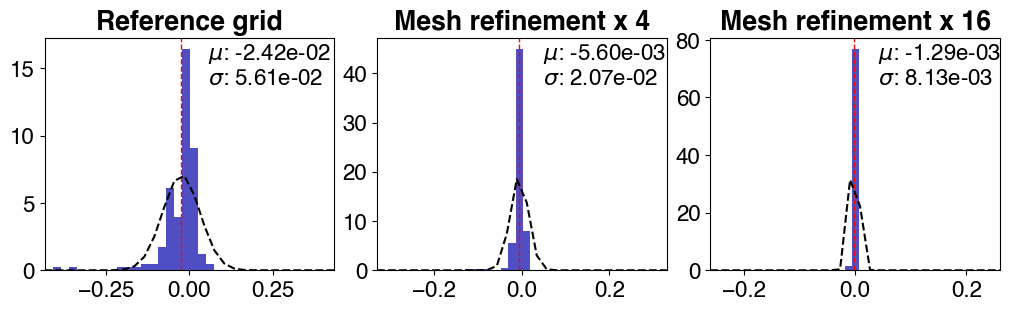

In [43]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 3)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1", "ax1-2", "ax1-3"]],
            sharey=False,
            sharex=False,
        )
    },
)

plot_histogram(plotter.get_axis("ax1-1"), (grad_adj_x1), "Reference grid")
plot_histogram(plotter.get_axis("ax1-2"), (grad_adj_x4), "Mesh refinement x 4")
plot_histogram(plotter.get_axis("ax1-3"), (grad_adj_x16), "Mesh refinement x 16")

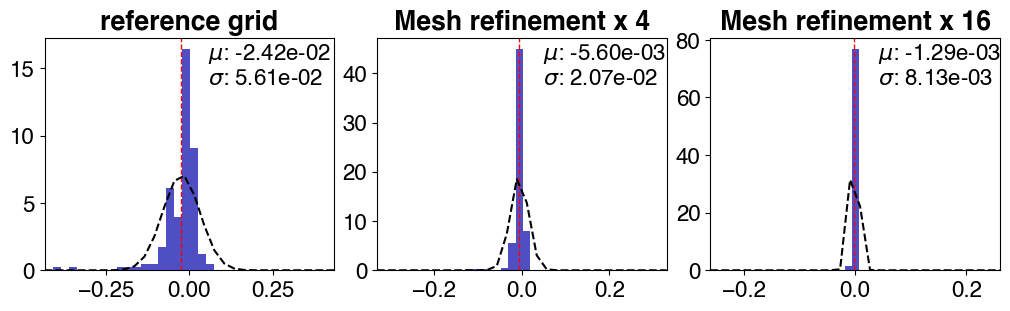

In [44]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 3)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1", "ax1-2", "ax1-3"]],
            sharey=False,
            sharex=False,
        )
    },
)

plot_histogram(plotter.get_axis("ax1-1"), (grad_fd_x1), "reference grid")
plot_histogram(plotter.get_axis("ax1-2"), (grad_fd_x4), "Mesh refinement x 4")
plot_histogram(plotter.get_axis("ax1-3"), (grad_fd_x16), "Mesh refinement x 16")

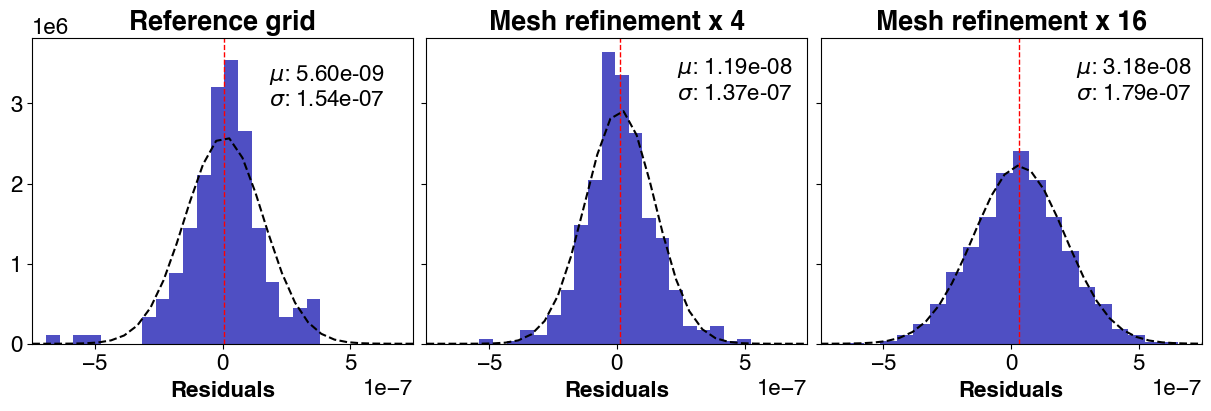

In [55]:
from matplotlib import ticker

plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (12, 4)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1", "ax1-2", "ax1-3"]],
            sharey=True,
            sharex=True,
        )
    },
)

plot_histogram(plotter.get_axis("ax1-1"), (grad_adj_x1 - grad_fd_x1), "Reference grid")
plot_histogram(
    plotter.get_axis("ax1-2"), (grad_adj_x4 - grad_fd_x4), "Mesh refinement x 4"
)
plot_histogram(
    plotter.get_axis("ax1-3"), (grad_adj_x16 - grad_fd_x16), "Mesh refinement x 16"
)

for ax in plotter.axes:
    # Y axis with scientific notation
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    # X labels
    ax.set_xlabel(f"Residuals", fontweight="bold")

fname = "error_distribution_2d"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [46]:
print(f"mean - grad x1 = {np.mean(grad_adj_x1)}")
print(f"mean - grad x4 = {np.mean(grad_adj_x4)}")
print(f"mean - grad x16 = {np.mean(grad_adj_x16)}")

mean - grad x1 = -0.02421081904140247
mean - grad x4 = -0.005600415600605863
mean - grad x16 = -0.0012901942120985578


In [47]:
print(f"mean - grad x1 = {np.mean(grad_adj_x1)}")
print(f"mean - grad x4 = {np.mean(grad_adj_x4)}")
print(f"mean - grad x16 = {np.mean(grad_adj_x16)}")

mean - grad x1 = -0.02421081904140247
mean - grad x4 = -0.005600415600605863
mean - grad x16 = -0.0012901942120985578


## Plot the gradients

In [48]:
production_locations = [(6, 3, 0), (14, 3, 0)]
injection_locations = [(2, 6, 0), (10, 6, 0), (18, 6, 0)]

nx = 21  # number of voxels along the x axis
ny = 8  # number of voxels along the y axis
nz = 1  # number of voxels along the y axis
# Give non regular dimensions to check if all is correct with mesh dimensions
dx = 8.43  # voxel dimension along the x axis
dy = 5.6
dz = 1.0  # voxel dimension along the y axis

geom_x1 = dmfwd.Geometry(nx=nx, ny=ny, dx=dx, dy=dy, dz=dz)

geom_x4 = copy.deepcopy(geom_x1)
geom_x4.nx *= 2
geom_x4.ny *= 2
geom_x4.dx /= 2
geom_x4.dy /= 2

geom_x16 = copy.deepcopy(geom_x1)
geom_x16.nx *= 4
geom_x16.ny *= 4
geom_x16.dx /= 4
geom_x16.dy /= 4

In [49]:
def plot_gradient_res(
    adj_grad: NDArrayFloat,
    fd_grad: NDArrayFloat,
    geom: dmfwd.Geometry,
    fname: str,
    grid_scaling: float = 1.0,
    res_scaling: Optional[float] = None,
) -> None:
    plotter = ngp.NestedGridPlotter(
        fig_params={"constrained_layout": True, "figsize": (10, 8)},
        subplots_mosaic_params={
            "fig0": dict(
                mosaic=[["ax1-1"], ["ax1-2"], ["ax1-3"]],
                sharey=True,
                sharex=True,
            )
        },
    )

    # We multiply the residuals so that the hight residulas is just below the max values
    residuals = adj_grad - fd_grad

    if res_scaling is None:
        res_factor = 1.0
        while np.max(np.abs(adj_grad)) > np.max(np.abs(residuals)) * res_factor:
            res_factor *= 2.0
        # Make sure it is below
        res_factor /= 2.0
    else:
        res_factor = res_scaling

    ngp.multi_imshow(
        axes=plotter.axes,
        fig=plotter.fig,
        data={
            "Finite differences": adj_grad,
            "Adjoint state": fd_grad,
            f"Residuals (x {res_factor:.0e})": residuals * res_factor,
        },
        imshow_kwargs={
            "extent": [0.0, geom.nx * geom.dx, 0.0, geom.ny * geom.dy],
            "aspect": "equal",
        },
        xlabel="X [m]",
        ylabel="Z [m]",
        is_symmetric_cbar=True,
    )

    # plotter.subfigs["fig0"].suptitle(
    #     "J Gradient with respect to permeability", fontweight="bold"
    # )

    for ax in plotter.ax_dict.values():
        # Add some vertical lines to indicate the well
        for well_pos in production_locations:
            ax.plot(
                well_pos[0] * grid_scaling * geom.dx + geom.dx / 2,
                well_pos[1] * grid_scaling * geom.dy + geom.dy / 2,
                label="prod wells",
                marker="^",
                markersize=10,
                c="black",
                linestyle="none",
            )

        for well_pos in injection_locations:
            ax.plot(
                well_pos[0] * grid_scaling * geom.dx + geom.dx / 2,
                well_pos[1] * grid_scaling * geom.dy + geom.dy / 2,
                label="inj wells",
                marker="^",
                markersize=10,
                c="red",
                linestyle="none",
            )

    for format in ["png", "pdf"]:
        plotter.fig.savefig(
            str(fig_save_path.joinpath(f"{fname}.{format}")), format=format
        )

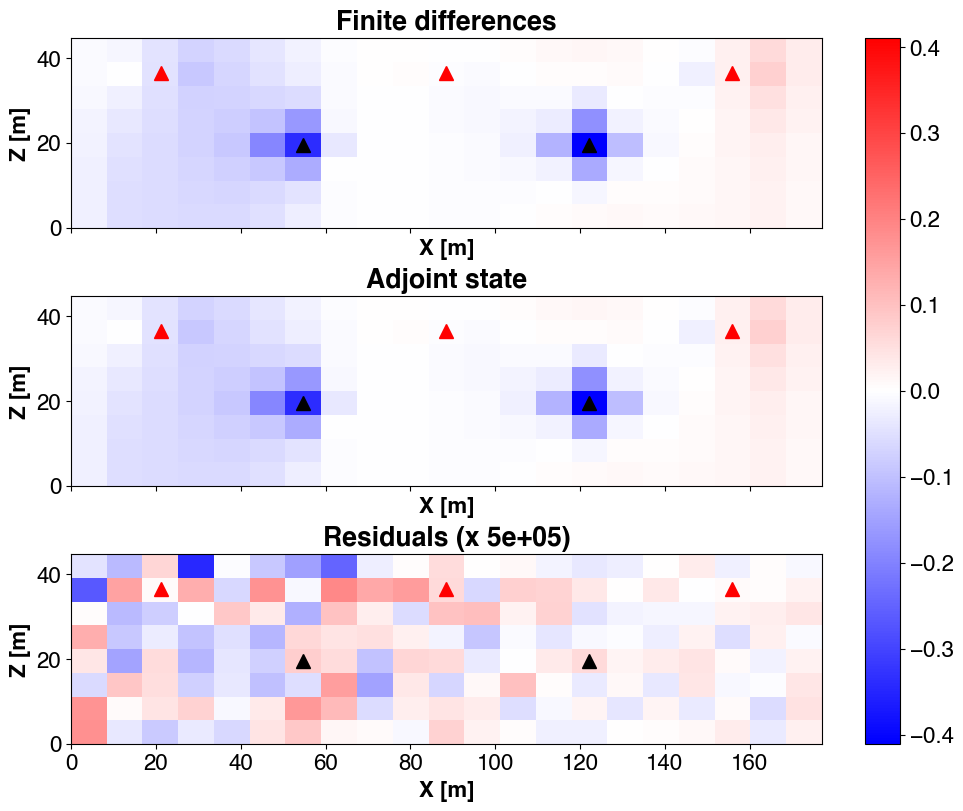

In [54]:
plot_gradient_res(
    grad_adj_x1, grad_fd_x1, geom_x1, "dj_dhc_2d_x1", grid_scaling=1, res_scaling=5e5
)

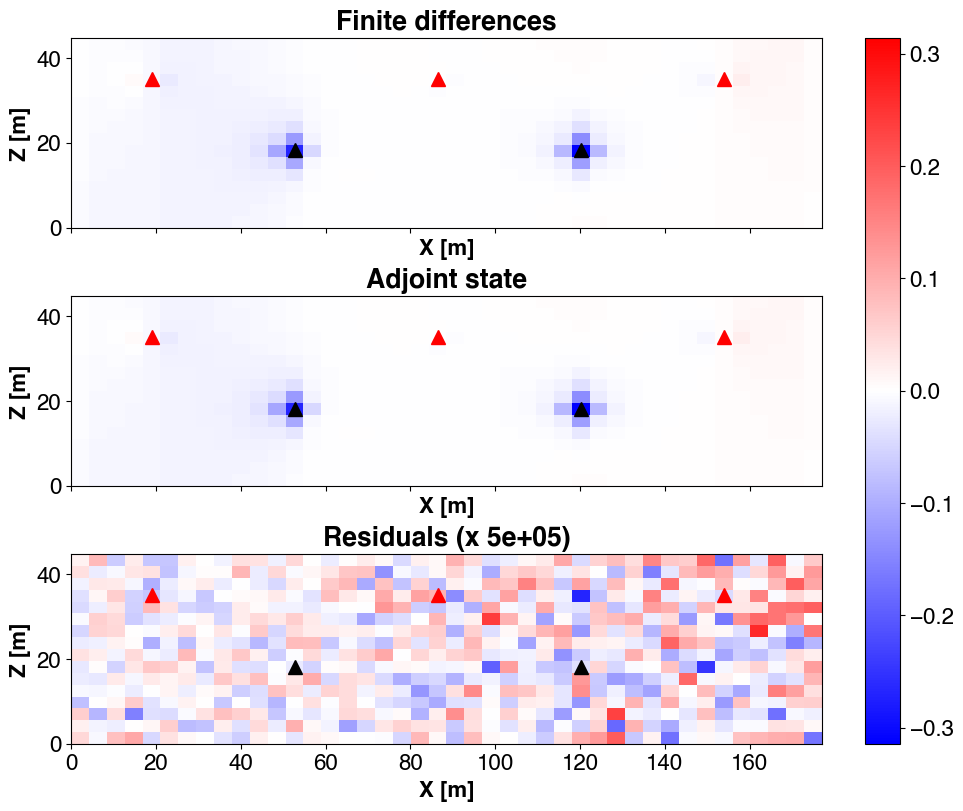

In [51]:
plot_gradient_res(
    grad_adj_x4, grad_fd_x4, geom_x4, "dj_dhc_2d_x4", grid_scaling=2, res_scaling=5e5
)

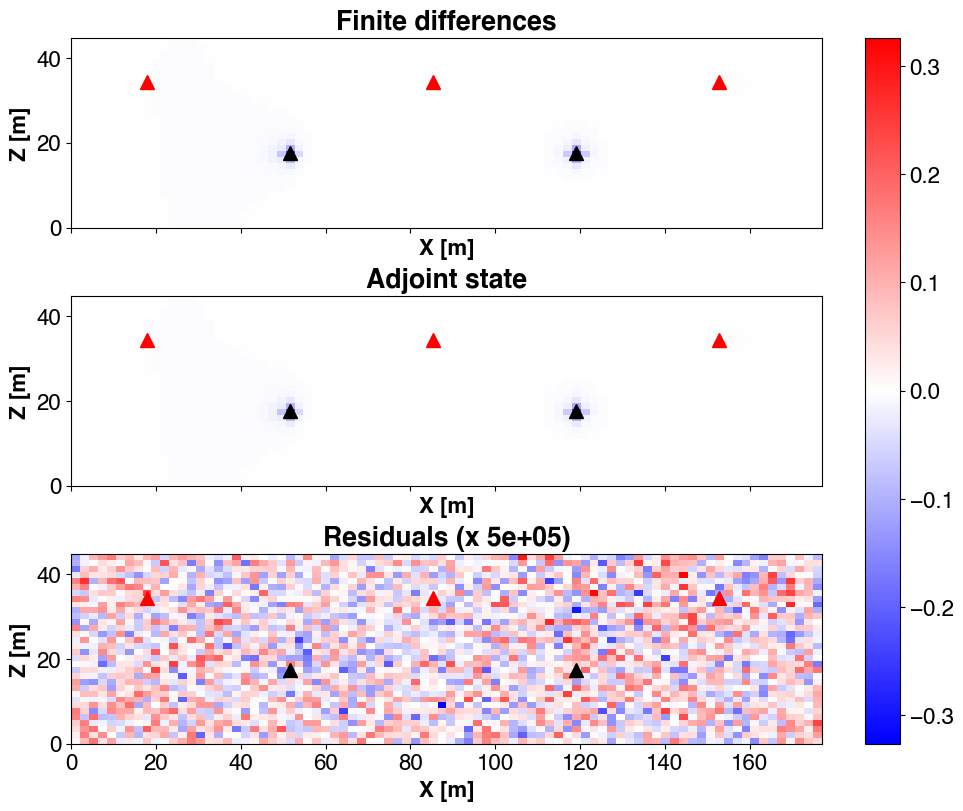

In [52]:
plot_gradient_res(
    grad_adj_x16,
    grad_fd_x16,
    geom_x16,
    "dj_dhc_2d_x16",
    grid_scaling=4,
    res_scaling=5e5,
)